The primary goal of this project is to predict whether a customer will subscribe to a term deposit, achieving at least 81% accuracy through 5‑fold cross validation. Beyond prediction, we aim to identify customer segments most likely to invest, highlight the key features driving purchase decisions, and provide interpretable insights that empower clients to prioritize outreach strategies effectively

# libraries

In [20]:
# basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Handling imbalanced dataset 
from imblearn.over_sampling import SMOTE 
from collections import Counter
# Convert Categorical Variable to Numeric
from sklearn.preprocessing import LabelEncoder 

# Modeling

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report ,ConfusionMatrixDisplay,f1_score
import warnings
warnings.filterwarnings("ignore")

In [21]:
Data=pd.read_csv("term-deposit-marketing-2020.csv")
Data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

- Output (desired target): y - has the client subscribed to a term deposit? (binary)



# Getting the Data Info

In [22]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


- Rows and columns: 40000 Rows, 14 columns
- Types of variables: 5 Numeric variables, 9 Categorical  variables

# Checking Missing Values

In [23]:
Data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

- It appears that the dataframe does not contain missing values overall. However, certain features do include null entries—specifically, 3,209 in Balance and 3 in Duration. Let’s examine a sample of these subsets.


# Data Visualization for Categorical Variables

- Categorical Variables: job, marital,education, default,housing, loan, contact,month,deposit

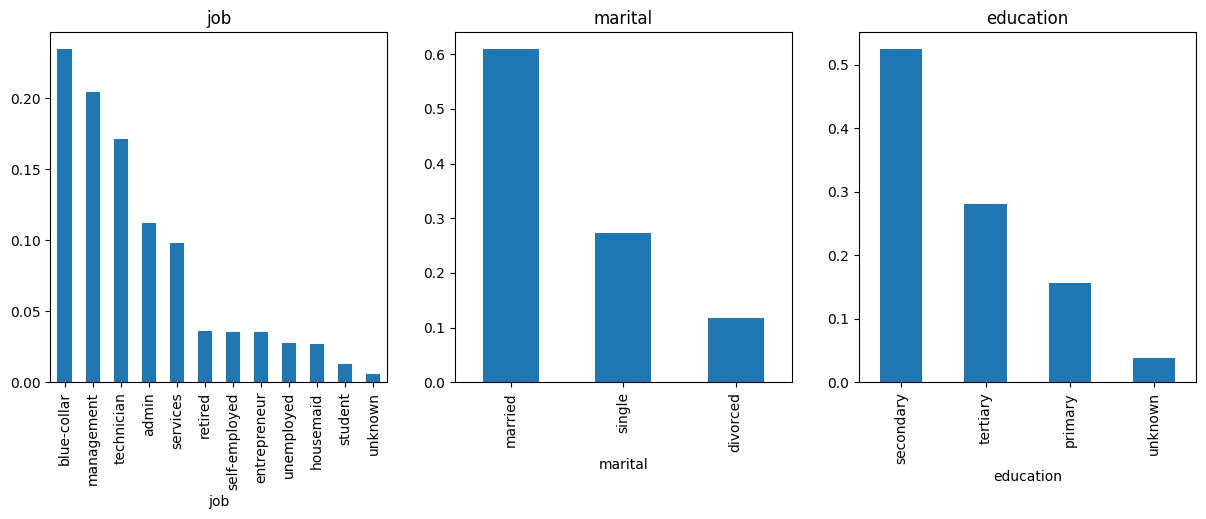

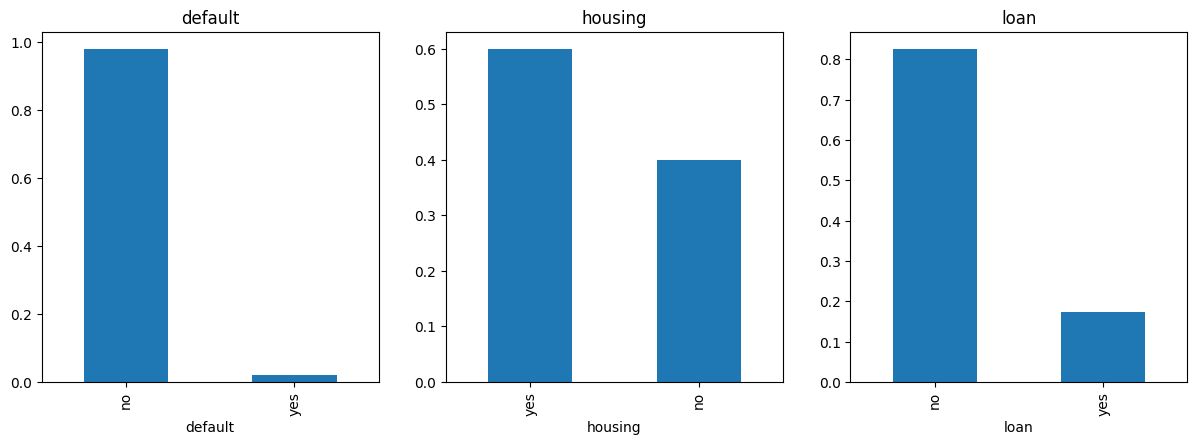

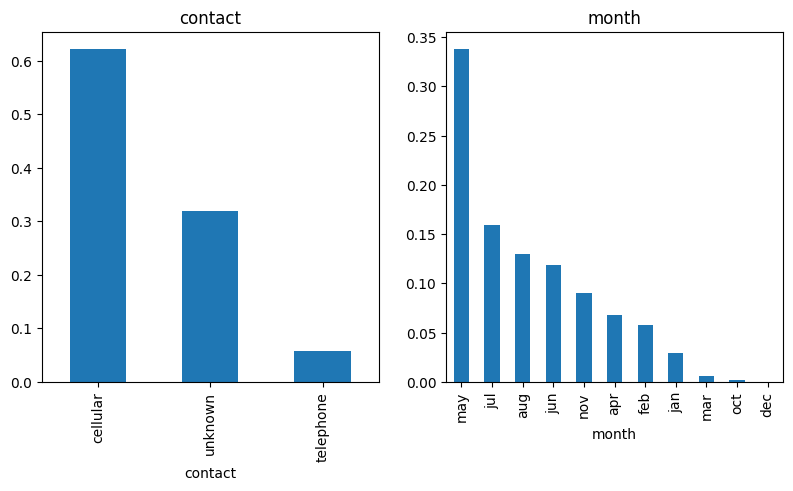

In [24]:
# 2.1.2. categorical variables

plt.figure(1)

plt.subplot(241)

Data['job'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='job')

plt.subplot(242)
Data['marital'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='marital')

plt.subplot(243)
Data['education'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='education')

plt.show()


plt.figure(2)

plt.subplot(241)
Data['default'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='default' )

plt.subplot(242)
Data['housing'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='housing')

plt.subplot(243)
Data['loan'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='loan')

plt.show()

plt.figure(1)

plt.subplot(241)
Data['contact'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='contact')

plt.subplot(242)
Data['month'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='month')



plt.show()

- From the results above, we can see that qualitative variables are divided into 2 groups: 3 binary variables, and 5 multi categorical variables
- The features which are having unknown class is job, education, contact

# Replacing unknown class with mode of the particular feature

In [25]:
Data["job"].replace(["unknown"],Data["job"].mode(),inplace = True)
Data["education"].replace(["unknown"],Data["education"].mode(),inplace = True)
Data["contact"].replace(["unknown"],Data["contact"].mode(),inplace = True)

# Segmentation and Classification Strategy

We set out to lower marketing expenses and maximize revenue by adopting a more strategic approach to customer outreach. Our method combined segmentation and classification, allowing us to move away from contacting all customers indiscriminately . Instead, we focused on identifying those most likely to show interest Term deposits.

# Customer Segmentation

We divided the features into two segments: **Demographic Segmentation:**  That included the following categories: age, job, marital,education,Default , Balance , Housing and Loan **Campaign Segmentation** This included the categories of Contact , Day, Month < Duration  and compaign 

In [26]:
features_to_drop = ['contact', 'day', 'month','duration','campaign']
Demo_Data= Data.drop(columns=features_to_drop)

In [27]:
Demo_Data.head()

,age,job,marital,education,default,balance,housing,loan,y
0,58,management,married,tertiary,no,2143,yes,no,no
1,44,technician,single,secondary,no,29,yes,no,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,no
3,47,blue-collar,married,secondary,no,1506,yes,no,no
4,33,blue-collar,single,secondary,no,1,no,no,no


# BIVARIATE ANALYSIS:

# Districution of customers Subscribed to Term Deposit 

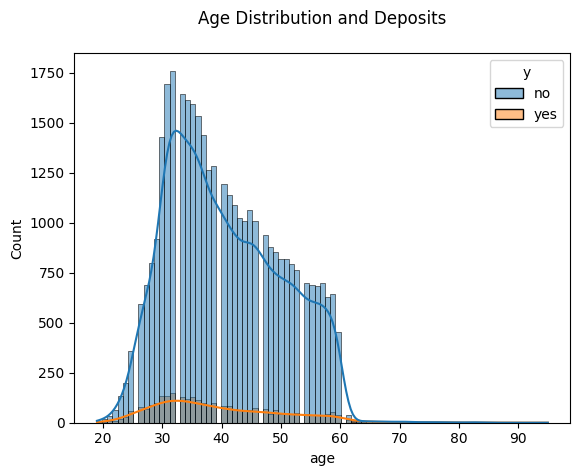

In [28]:
sns.histplot(x="age", data=Demo_Data, kde=True, hue= "y")
plt.title("Age Distribution and Deposits\n")
plt.show()

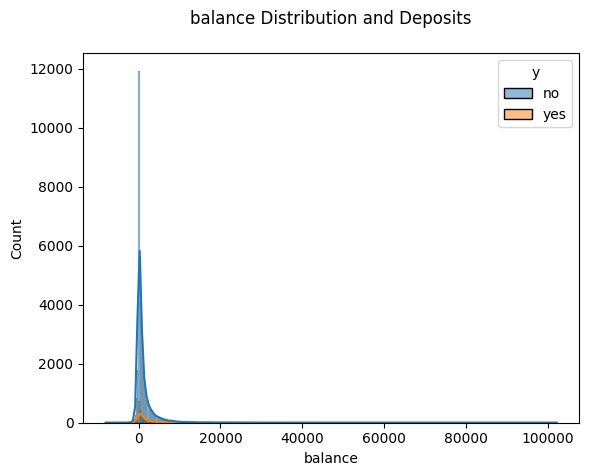

In [29]:
sns.histplot(x="balance", data=Demo_Data, kde=True, hue= "y")
plt.title("balance Distribution and Deposits\n")
plt.show()

In [30]:
Demo_Data_ANALYSIS= Demo_Data.drop(columns=['age','balance'])
Demo_Data_ANALYSIS.head()

,job,marital,education,default,housing,loan,y
0,management,married,tertiary,no,yes,no,no
1,technician,single,secondary,no,yes,no,no
2,entrepreneur,married,secondary,no,yes,yes,no
3,blue-collar,married,secondary,no,yes,no,no
4,blue-collar,single,secondary,no,no,no,no


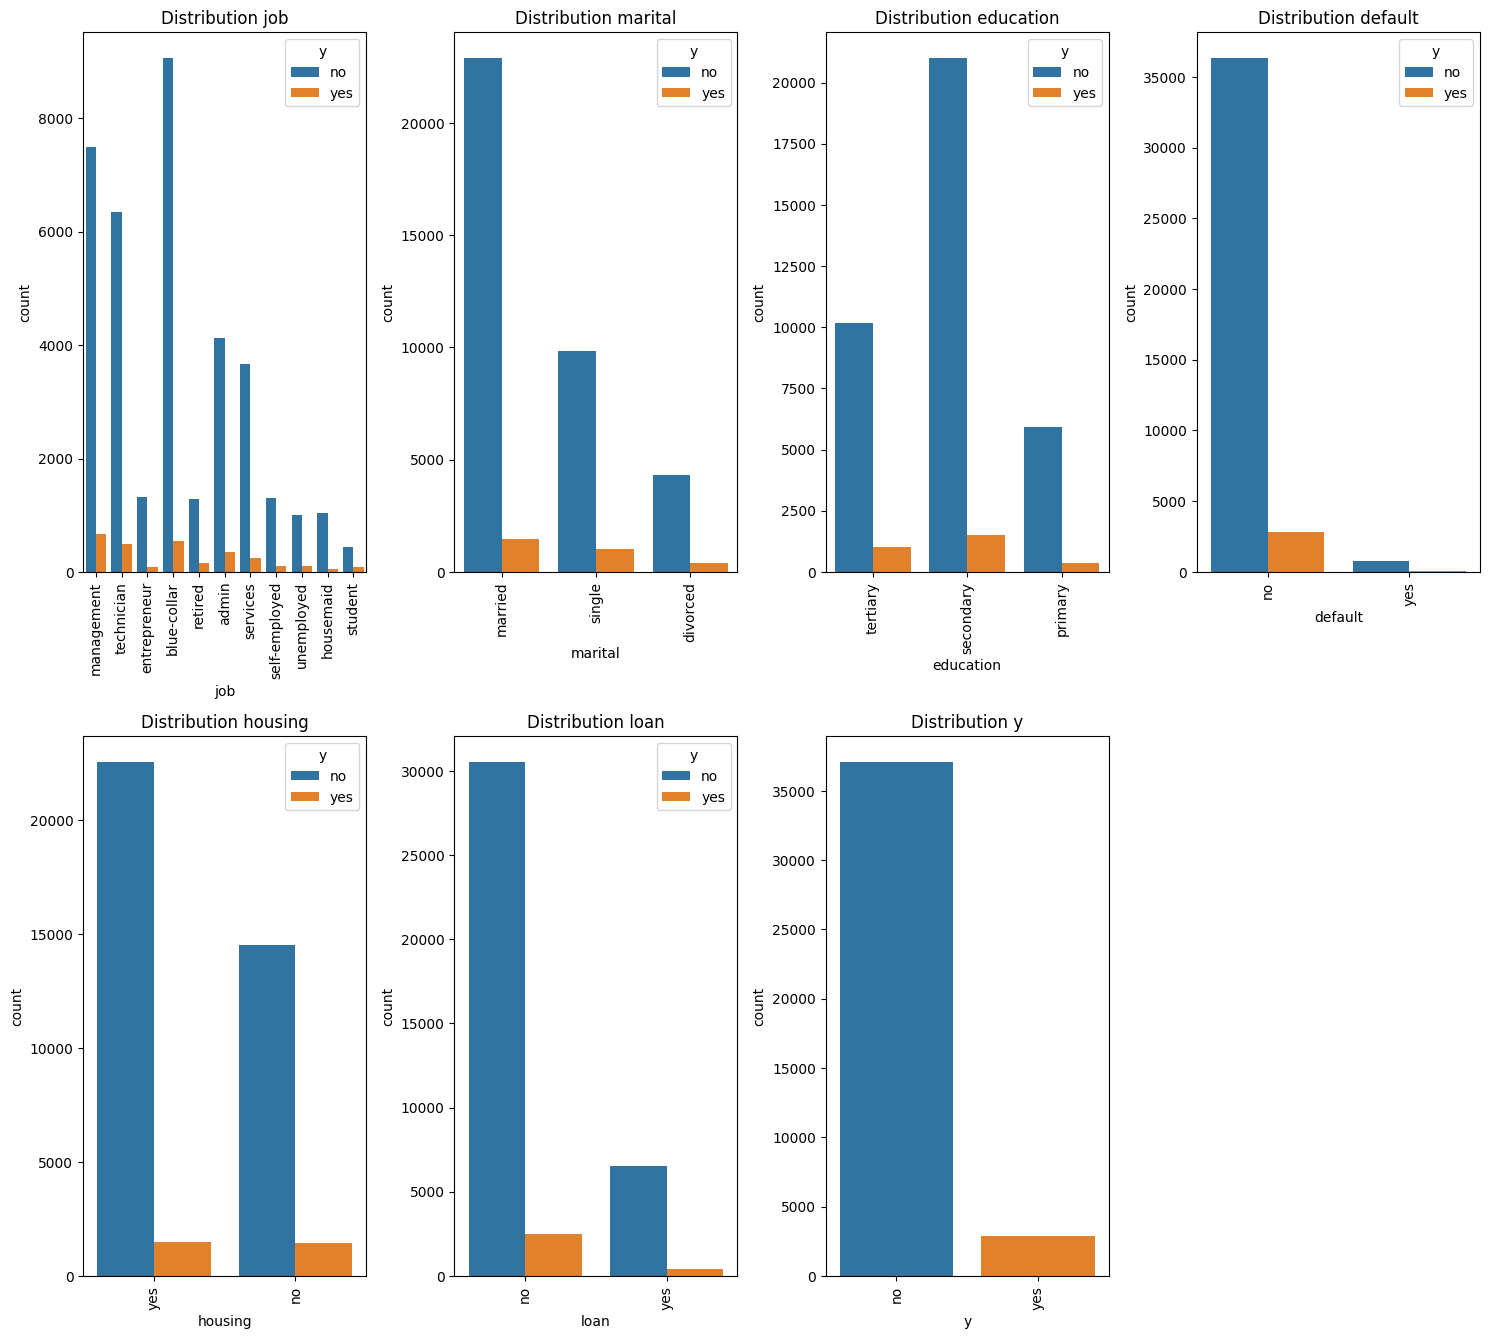

In [31]:
plt.figure(figsize=(15, 20))
for i, feature in enumerate(Demo_Data_ANALYSIS.columns):
    plt.subplot(3, 4, i+1)
    sns.countplot(data=Demo_Data_ANALYSIS, x=feature, hue='y')
    plt.title(f'Distribution {feature}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Remarks : 

- The majority of clients are within the 20–60 age range, with individuals aged 30–40 showing the highest likelihood of subscribing to term deposits.

- From the graph, we can infer that clients represented by the blue-collar , management and administrative roles are more likely to subscribe to a term deposit.

- A Married customers has higher likelihood of subscribing to term deposits, divorced people are broken and are less likely subscribe 

- Secondary, the higher  level rate of subscription

- A customer with no Personal loan has a higher subscription rate

-  Person who has past housing loan seems slightly high subscribe to Term Desposit compared to those who doesn,t have Housinh loan

# Check Imbalanced Dataset

Text(0.5, 1.0, 'Distribution of client subscribed to a term deposit')

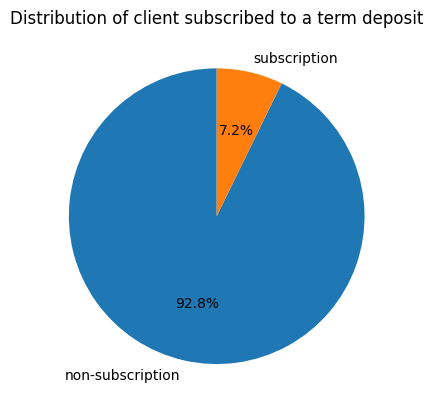

In [32]:
# y_count=Data["y"].value_counts(normalize=True)
labels = ['non-subscription', 'subscription']
Demo_Data["y"].value_counts(normalize=True)
plt.pie(Demo_Data['y'].value_counts(),labels=labels,autopct='%1.1f%%', startangle=90)
plt.title('Distribution of client subscribed to a term deposit')

- Since 92% of clients did not subscribe to a term deposit, the dataset is highly imbalanced. Therefore, relying solely on accuracy would be misleading. Instead, it is more appropriate to evaluate the model using alternative metrics such as recall, precision, or the F1 score.

## # Convert Categorical Variable to Numeric

- Transforming categorical data into numerical form is a crucial step in preprocessing for machine learning. Since most algorithms operate on numerical inputs, this conversion guarantees compatibility, enhances model accuracy, and enables more effective feature engineering.

In [44]:
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()
Demo_Data['job'] = lbe.fit_transform(Demo_Data['job'])
Demo_Data['marital'] = lbe.fit_transform(Demo_Data['marital'])
Demo_Data['education'] = lbe.fit_transform(Demo_Data['education'])
Demo_Data['default'] = lbe.fit_transform(Demo_Data['default'])
Demo_Data['housing'] = lbe.fit_transform(Demo_Data['housing'])
Demo_Data['loan'] = lbe.fit_transform(Demo_Data['loan'])
Demo_Data['y'] = lbe.fit_transform(Demo_Data['y'])
Demo_Data.head()

,age,job,marital,education,default,balance,housing,loan,y
0,58,4,1,2,0,2143,1,0,0
1,44,9,2,1,0,29,1,0,0
2,33,2,1,1,0,2,1,1,0
3,47,1,1,1,0,1506,1,0,0
4,33,1,2,1,0,1,0,0,0


# Checking for Correlation among the Predictors

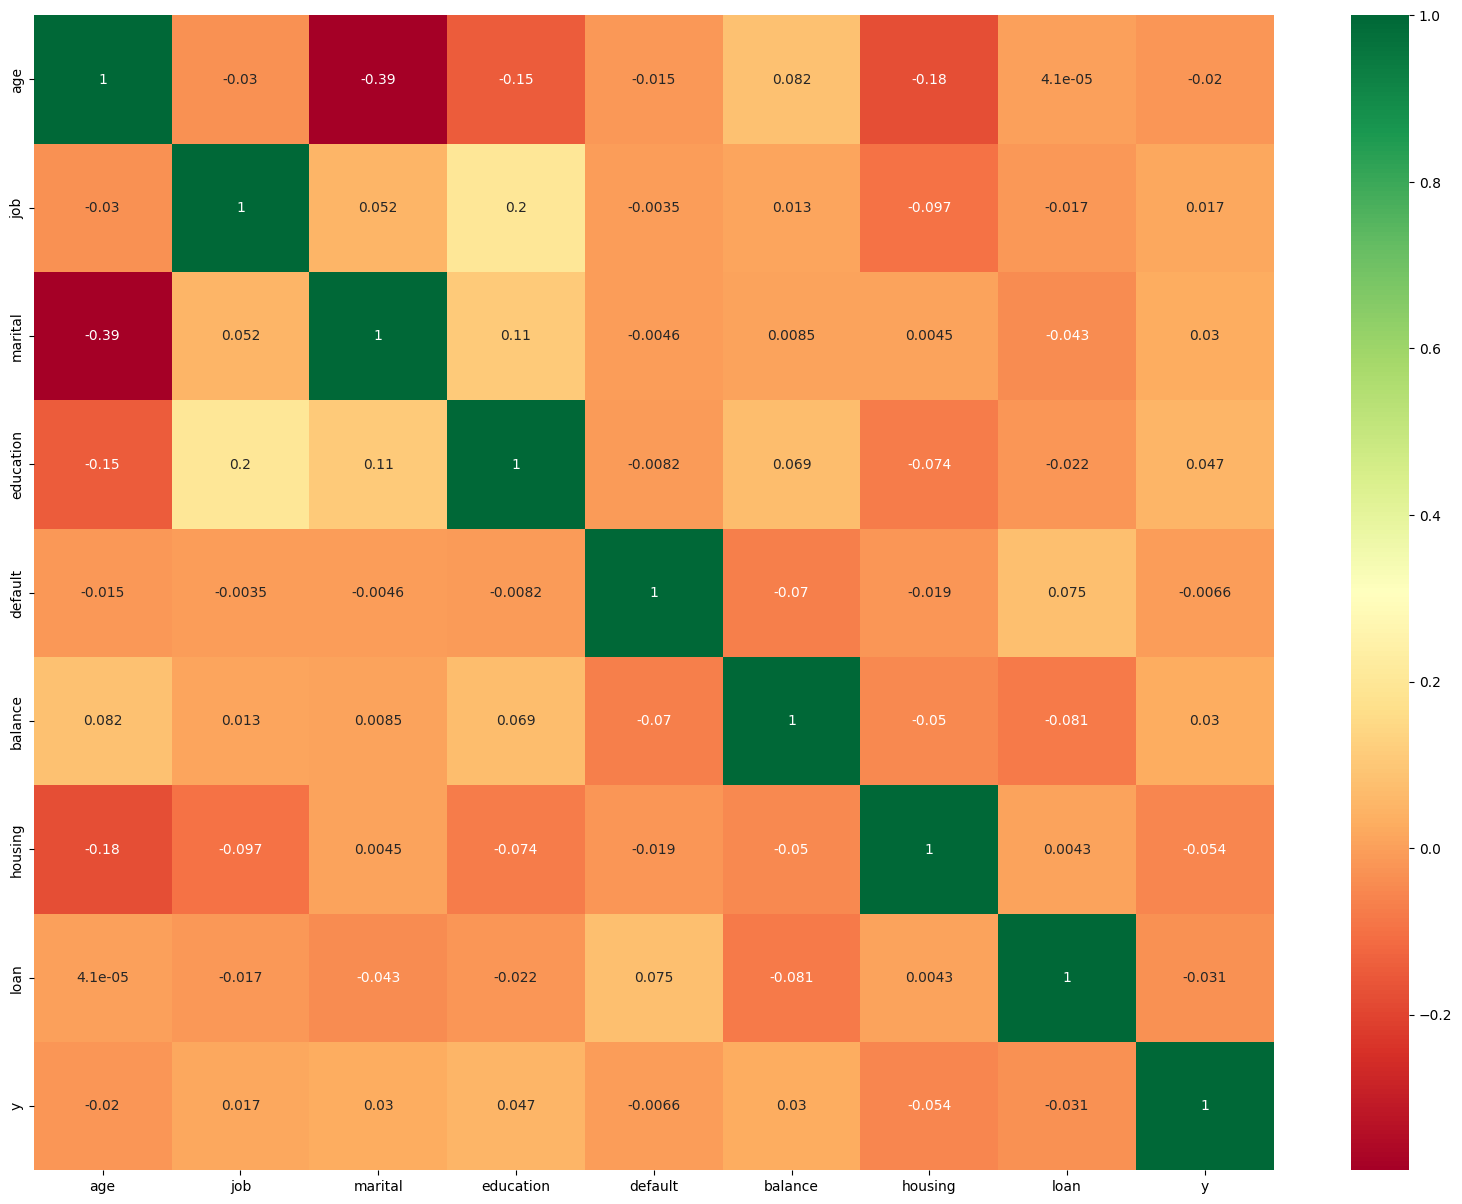

In [45]:
corr = Demo_Data.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

### We can see clearly that : 

- Most correlated variable are Job and Education 

# Handling Class Imbalance Using Random Under Sampler

In [46]:
Y=Demo_Data['y']
X = Demo_Data.drop('y',axis = 1)
Y_train, Y_test, X_train, X_test = train_test_split(Y, X, test_size=0.2, random_state=423)

In [47]:
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [48]:
print("Original class distribution:", Counter(Y))

undersample = RandomUnderSampler(sampling_strategy='majority')

X_under, Y_under = undersample.fit_resample(X_train, Y_train)

print("Undersampled class distribution:", Counter(Y_under))

Original class distribution: Counter({0: 37104, 1: 2896})
Undersampled class distribution: Counter({0: 2290, 1: 2290})


Text(0.5, 1.0, 'Distribution of client subscribed to a term deposit')

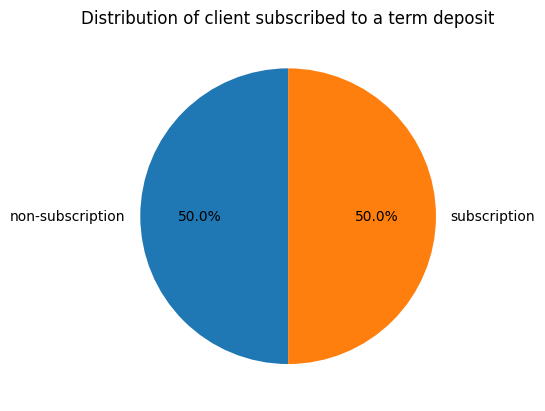

In [49]:
labels = ['non-subscription', 'subscription']
          
Y_under.value_counts(normalize=True)
plt.pie(Y_under.value_counts(),labels=labels,autopct='%1.1f%%', startangle=90)
plt.title('Distribution of client subscribed to a term deposit')

# Features Importance 

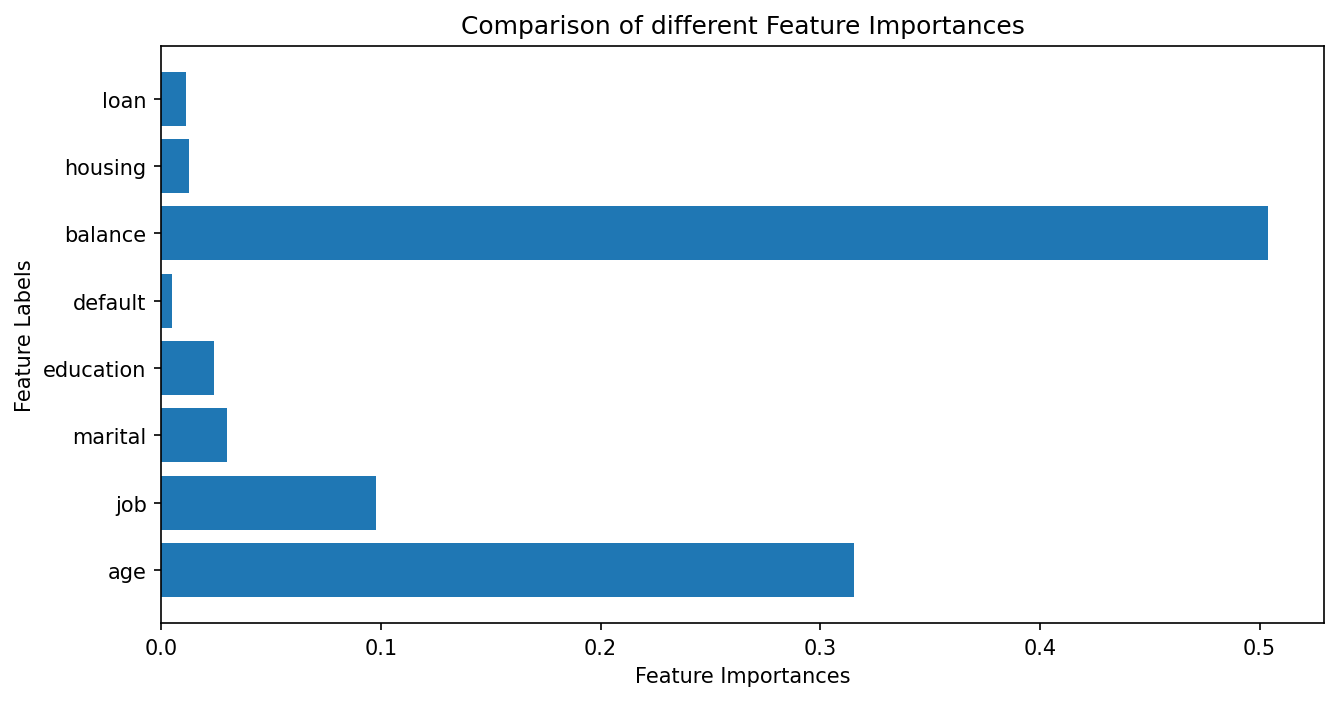

In [50]:
from sklearn.ensemble import ExtraTreesClassifier
plt.figure(figsize=(10, 5), dpi=150)
model_Demo = ExtraTreesClassifier()
model_Demo.fit(X_under,Y_under)

feat_importances =model_Demo.feature_importances_
plt.barh(X.columns, feat_importances)
plt.xlabel('Feature Importances')
plt.ylabel('Feature Labels')
plt.title('Comparison of different Feature Importances')
plt.show()

"The analysis shows that Age, Balance, Job, Marital status, and Education are the most impactful features in the dataset. Therefore, the company should focus primarily on Age, Balance, and Job when developing strategies to identify the most suitable clients to contact.

# Model Building

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [52]:
RF =  RandomForestClassifier()
DTR = DecisionTreeClassifier()
KNN = KNeighborsClassifier()
LR = LogisticRegression()
SVC = SVC()

models = [RF, DTR, KNN, LR, SVC]
metrics_list = []

for model in models:
    model.fit(X_under, Y_under)
    y_pred_train = model.predict(X_under)
    y_pred_test = model.predict(X_test)

    accuracy_train = metrics.accuracy_score(Y_under, y_pred_train)
    accuracy_test = metrics.accuracy_score(Y_test, y_pred_test)
    accuracy_metrics = {'Algorithm'    : str(model).split('(')[0],
                        'Accuracy_Train': accuracy_train,
                        'Accuracy_Test' : accuracy_test
                       }

    metrics_list.append(accuracy_metrics)

In [54]:
Demo_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int64
 2   marital    40000 non-null  int64
 3   education  40000 non-null  int64
 4   default    40000 non-null  int64
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int64
 7   loan       40000 non-null  int64
 8   y          40000 non-null  int64
dtypes: int64(9)
memory usage: 2.7 MB


In [125]:
Best_cls_model =pd.DataFrame(metrics_list)
Best_cls_model

,Algorithm,Accuracy_Train,Accuracy_Test
0,RandomForestClassifier,0.99,0.56
1,DecisionTreeClassifier,0.99,0.54
2,KNeighborsClassifier,0.70,0.55
3,LogisticRegression,0.57,0.59
4,SVC,0.55,0.70


# KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.93      0.55      0.69      7394
           1       0.09      0.51      0.15       606

    accuracy                           0.55      8000
   macro avg       0.51      0.53      0.42      8000
weighted avg       0.87      0.55      0.65      8000



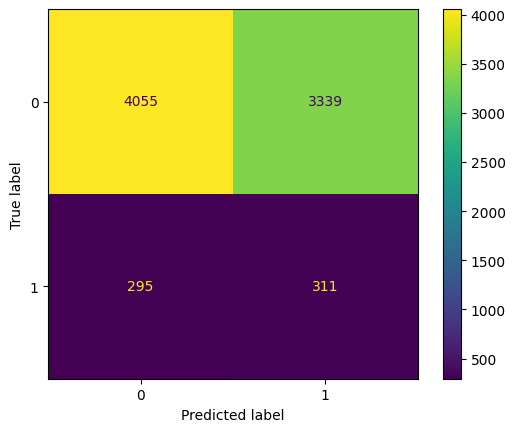

In [126]:
model_KNC = KNeighborsClassifier()
model_KNC.fit(X_under, Y_under)
Y_pred_KNC = model_KNC.predict(X_test)
model_KNC = accuracy_score(Y_test, Y_pred_KNC)
print(classification_report(Y_test, Y_pred_KNC))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_KNC)
plt.show()

# DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.94      0.54      0.68      7394
           1       0.09      0.57      0.16       606

    accuracy                           0.54      8000
   macro avg       0.52      0.55      0.42      8000
weighted avg       0.87      0.54      0.64      8000



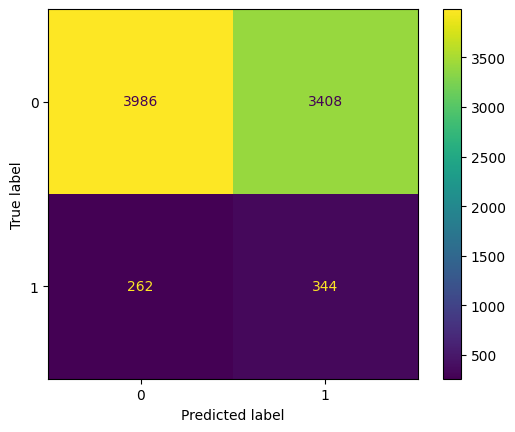

In [127]:
model_DT = DecisionTreeClassifier()
model_DT.fit(X_under, Y_under)
Y_pred_DT = model_DT.predict(X_test)
model_DT = accuracy_score(Y_test, Y_pred_DT)
print(classification_report(Y_test, Y_pred_DT))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_DT)
plt.show()

# LogisticRegression

              precision    recall  f1-score   support

           0       0.94      0.59      0.73      7394
           1       0.10      0.54      0.17       606

    accuracy                           0.59      8000
   macro avg       0.52      0.57      0.45      8000
weighted avg       0.88      0.59      0.69      8000



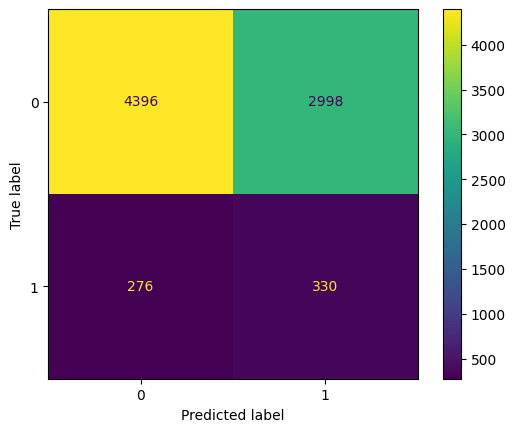

In [128]:
model_LG = LogisticRegression()
model_LG.fit(X_under, Y_under)
Y_pred_LG = model_LG.predict(X_test)
model_LG = accuracy_score(Y_test, Y_pred_LG)
print(classification_report(Y_test, Y_pred_LG))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_LG)
plt.show()

# SVC

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      7394
           1       0.09      0.32      0.14       606

    accuracy                           0.70      8000
   macro avg       0.51      0.53      0.48      8000
weighted avg       0.87      0.70      0.77      8000



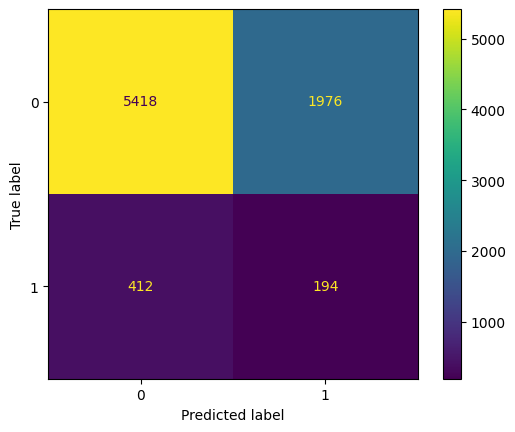

In [129]:
model_SVC = SVC()
model_SVC.fit(X_under, Y_under)
Y_pred_SVC = model_SVC.predict(X_test)
score_SVC = accuracy_score(Y_test, Y_pred_SVC)
print(classification_report(Y_test, Y_pred_SVC))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_SVC)
plt.show()

# RandomForestClassifier

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      7394
           1       0.09      0.55      0.16       606

    accuracy                           0.56      8000
   macro avg       0.52      0.56      0.43      8000
weighted avg       0.88      0.56      0.66      8000



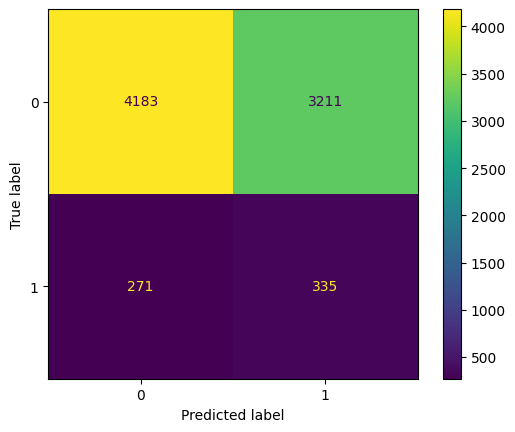

In [130]:
model_RF_ = RandomForestClassifier()
model_RF_.fit(X_under, Y_under)
Y_pred_RF_ = model_RF_.predict(X_test)
score_RF_ = accuracy_score(Y_test, Y_pred_RF_)
print(classification_report(Y_test, Y_pred_RF_))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_RF_)
plt.show()

Remark:
Based on the above results, we can see that the SVC Model is the best for predicting and f1 score of 0.15 on all models , but accurancy is higher than the other 4 models. and 09 for true negatives in the confusion matrix.

# Conclusion and Key Insights


The current marketing campaign depends on repeated phone calls to secure product subscriptions. To improve efficiency and reduce costs, it is recommended that the bank first identify clients with the highest probability of subscribing to a term deposit. By prioritizing these clients for outreach, the campaign can minimize unnecessary calls, optimize resource allocation, and achieve better conversion rates.

Exploratory Data Analysis (EDA):

- The age distribution of clients highlighted that the majority fell in the 30-40 age range, coinciding with the highest subscription rate for term deposits.
- Occupation-wise, clients in administrative, blue-collar and management roles formed the majority and were more likely to subscribe to term deposits.
- Marital status leaned heavily toward the "married" category.
- Clients with university degrees or high-level education were more prominent and had a higher subscription rate.
- Credit defaults were rare, with the vast majority of clients having no credit defaults.
- Clients with housing loans are slightly more likely to subscribe to term deposits, while those with personal loans were less likely.


# Hyperparameter Optimizations

# Till Here 